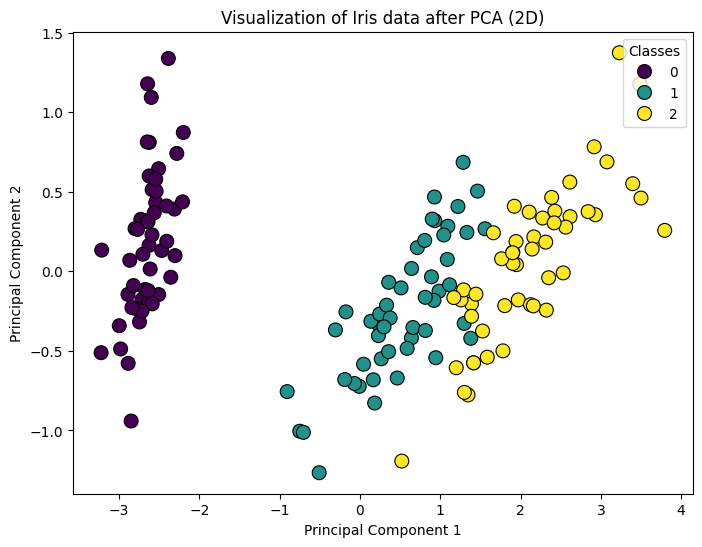

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# Load the Iris dataset
data = load_iris()
X = data.data  # Flower features (4 dimensions)
y = data.target  # Flower classes

# Visualize the original data with PCA (projected to 2D)
def visualize_data_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis", s=100, edgecolor='k')
    plt.title("Visualization of Iris data after PCA (2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Classes", loc="upper right")
    plt.show()

# Call the function to visualize the original data
visualize_data_pca(X, y)


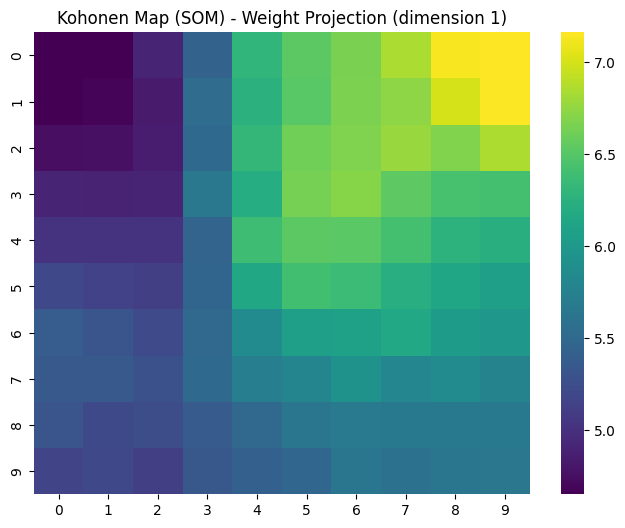

In [3]:
# Initialization of the Kohonen map (KSOM)
map_width = 10
map_height = 10
n_features = X.shape[1]  # Number of input features (4 dimensions in the Iris dataset)

# Initialize random weights for each neuron on the map
weights = np.random.rand(map_width, map_height, n_features)

# Learning parameters
learning_rate = 0.5
n_iterations = 10000
initial_radius = max(map_width, map_height) / 2
time_constant = n_iterations / np.log(initial_radius)

# Euclidean distance function
def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)

# Find the Best Matching Unit (BMU)
def find_bmu(input_vector, weights):
    bmu_idx = None
    min_dist = np.inf

    # Compare each neuron
    for i in range(map_width):
        for j in range(map_height):
            w = weights[i, j]
            dist = euclidean_distance(input_vector, w)
            if dist < min_dist:
                min_dist = dist
                bmu_idx = (i, j)

    return bmu_idx

# Mexican Hat function for influence calculation
def mexican_hat_function(dist_to_bmu, radius):
    gaussian_part = np.exp(-dist_to_bmu**2 / (2 * radius**2))  # Gaussian (excitation) part
    inhibitory_part = np.exp(-dist_to_bmu**2 / (radius**2))  # Inhibitory part
    return gaussian_part - inhibitory_part  # Excitation minus inhibition

# Update the weights of the neurons using Mexican Hat
def update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights, map_width, map_height, learning_rate, time_constant):
    # Calculate the neighborhood radius with exponential decay
    radius = initial_radius * np.exp(-iteration / time_constant)

    # Update the weights of the neurons in the neighborhood of the BMU
    for i in range(map_width):
        for j in range(map_height):
            w = weights[i, j]
            dist_to_bmu = euclidean_distance(np.array([i, j]), np.array(bmu_idx))

            # If the neuron is within the neighborhood
            if dist_to_bmu < radius:
                # Apply the Mexican Hat function to calculate influence
                influence = mexican_hat_function(dist_to_bmu, radius)
                # Update the weights based on the calculated influence
                weights[i, j] += influence * learning_rate * (input_vector - w)

    return weights

# Training the KSOM with Mexican Hat
for iteration in range(n_iterations):
    # Select a random input vector
    input_vector = X[np.random.randint(0, X.shape[0])]

    # Find the Best Matching Unit (BMU)
    bmu_idx = find_bmu(input_vector, weights)

    # Update the weights of the BMU and neighboring neurons with the Mexican Hat function
    weights = update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights, map_width, map_height, learning_rate, time_constant)

    # Decrease the learning rate over iterations
    learning_rate = 0.5 * np.exp(-iteration / n_iterations)

# Visualization of the Kohonen map weights (1D projection)
def visualize_som_weights(weights):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights[:, :, 0], cmap="viridis", annot=False, cbar=True)
    plt.title("Kohonen Map (SOM) - Weight Projection (dimension 1)")
    plt.show()

# Call the function to visualize the heatmap after KSOM training
visualize_som_weights(weights)


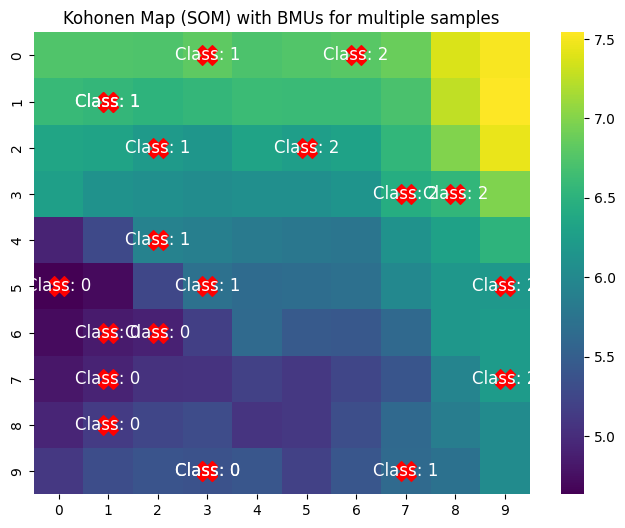

In [15]:
# Function to make an inference with a new input vector
def infer_som(input_vector, weights):
    # Find the BMU for the new input vector
    bmu_idx = find_bmu(input_vector, weights)
    return bmu_idx

# Visualize the map with multiple BMUs
def visualize_bmu_multiple(bmu_indices, weights, sample_classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights[:, :, 0], cmap="viridis", annot=False, cbar=True)
    plt.title("Kohonen Map (SOM) with BMUs for multiple samples")

    # Add markers for each BMU
    for idx, bmu_idx in enumerate(bmu_indices):
        plt.scatter(bmu_idx[1] + 0.5, bmu_idx[0] + 0.5, s=200, c='red', marker='X')
        plt.text(bmu_idx[1] + 0.5, bmu_idx[0] + 0.5, f"Class: {sample_classes[idx]}", color='white', fontsize=12, ha='center', va='center')

    plt.show()

# Function to randomly select n samples and perform inference
def test_inference_on_random_samples(n_samples, X, y, weights):
    # Select n random indices from the dataset
    sample_indices = np.random.choice(range(len(X)), size=n_samples, replace=False)
    bmu_indices = []
    sample_classes = []

    # For each randomly selected sample, perform inference and store the BMUs and classes
    for idx in sample_indices:
        new_data = X[idx]
        real_class = y[idx]  # Actual class of the sample
        bmu_idx = infer_som(new_data, weights)

        bmu_indices.append(bmu_idx)
        sample_classes.append(real_class)

    # Visualize the Kohonen map with BMUs for the random samples
    visualize_bmu_multiple(bmu_indices, weights, sample_classes)

# Example usage: Test the inference on 10 random samples
test_inference_on_random_samples(20, X, y, weights)
